n this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent [Deep Energy-Based Generative Models](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) tutorial created by Phillip Lippe.

#### Energy Based Models
Energy-based models are a broad class of generative model
that borrow a key idea from modeling physical systems—
namely, that the probability of an event can be expressed
using a Boltzmann distribution, a specific function that
normalizes a real-valued energy function between 0 and 1.
This distribution was originally formulated in 1868 by
Ludwig Boltzmann, who used it to describe gases in
thermal equilibrium.


##### THE LONG-AU-VIN RUNNING CLUB

Diane Mixx was head coach of the long-distance running
team in the fictional French town of Long-au-Vin. She
was well known for her exceptional abilities as a trainer
and had acquired a reputation for being able to turn
even the most mediocre of athletes into world-class
runners

Her methods were based around assessing the energy
levels of each athlete. Over years of working with
athletes of all abilities, she had developed an incredibly
accurate sense of just how much energy a particular
athlete had left after a race, just by looking at them. The
lower an athlete’s energy level, the better—elite athletes
always gave everything they had during the race!

To keep her skills sharp, she regularly trained herself by
measuring the contrast between her energy sensing
abilities on known elite athletes and the best athletes
from her club. She ensured that the divergence between her predictions for these two groups was as large as
possible, so that people would take her seriously if she
said that she had found a true elite athlete within her
club.

The real magic was her ability to convert a mediocre
runner into a top-class runner. The process was simple
—she measured the current energy level of the athlete
and worked out the optimal set of adjustments the
athlete needed to make to improve their performance
next time. Then, after making these adjustments, she
measured the athlete’s energy level again, looking for it
to be slightly lower than before, explaining the improved
performance on the track. This process of assessing the
optimal adjustments and taking a small step in the right
direction would continue until eventually the athlete
was indistinguishable from a world-class runner.

After many years Diane retired from coaching and
published a book on her methods for generating elite
athletes—a system she branded the “Long-au-Vin, Diane
Mixx” technique.


In [22]:
from tensorflow.keras import datasets,layers, metrics, losses, utils, callbacks, models,optimizers,activations
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import sample_batch, display
import random

In [1]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

#### Energy-Based Models
Energy-based models attempt to model the true data-generating distribution using a Boltzmann distribution
(Equation 7-1) where E(x) is know as the energy function
(or score) of an observation x

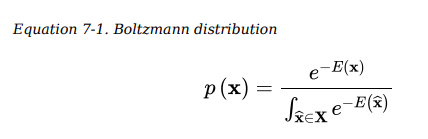

In [5]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [6]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [7]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

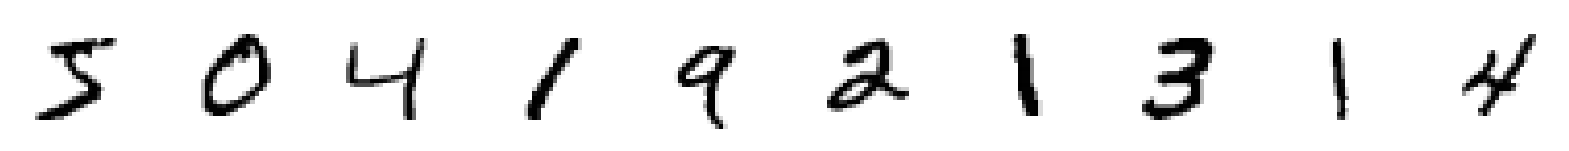

In [10]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

2. Build the EBM network

In [13]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

2. Set up a Langevin sampler function


In [14]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

3. Set up a buffer to store examples


In [16]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

#### EBM with Contrastive Divergence Loss

In [15]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [17]:
ebm = EBM()


3. Train the EBM network


In [18]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [19]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [20]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60


469/469 [==============================] - ETA: 0s - loss: -0.0265 - reg: 0.0090 - cdiv: -0.0355 - real: 0.1654 - fake: 0.1299
Saved to ./output/generated_img_000.png


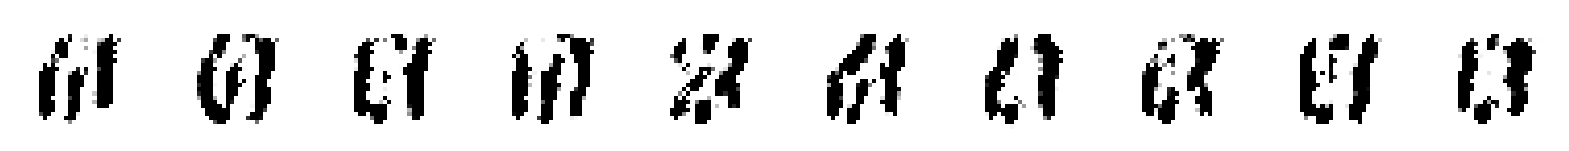


Saved to ./output/example_img_000.png


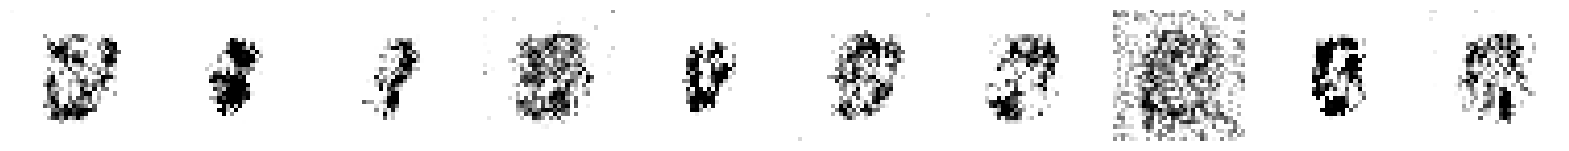

469/469 [==============================] - 832s 2s/step - loss: -0.0265 - reg: 0.0090 - cdiv: -0.0355 - real: 0.1654 - fake: 0.1299 - val_cdiv: -1.1464 - val_real: -0.0687 - val_fake: -1.2151
Epoch 2/60
 21/469 [>.............................] - ETA: 12:42 - loss: -0.0134 - reg: 0.0026 - cdiv: -0.0160 - real: 0.0467 - fake: 0.0307

KeyboardInterrupt: 

In [23]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

4. Generate images


In [24]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

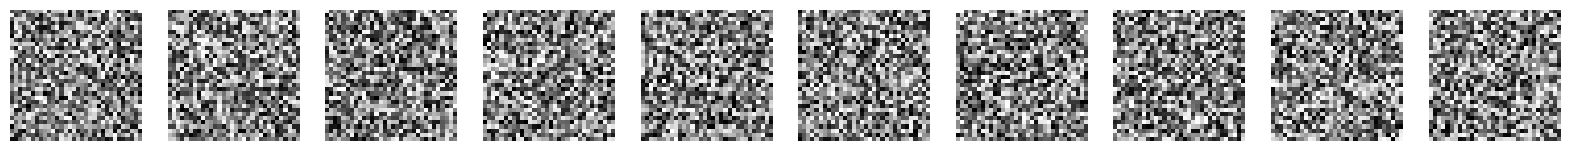

In [25]:
display(start_imgs)


In [26]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

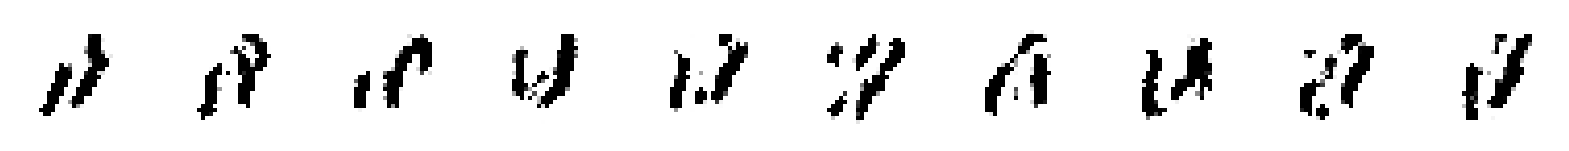

In [27]:
display(gen_img[-1].numpy())


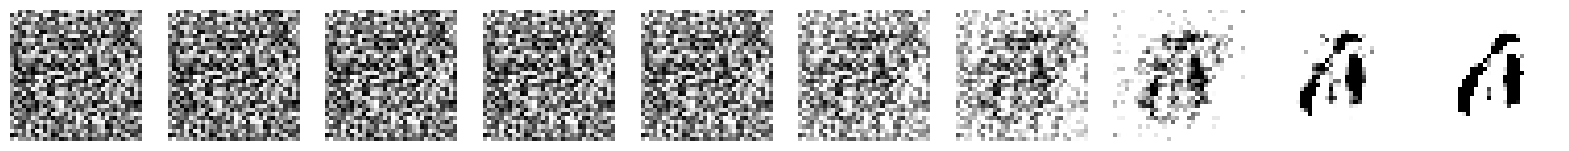

In [28]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))